## setup

In [1]:
import pandas as pd
import numpy as np
import cv2
import os
import time
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
from PIL import Image

# show all dataframe
pd.set_option('display.max_colwidth', None) 
pd.set_option('display.max_columns', None)  

## params

In [7]:
directory = 'test' # select the folder, no / at the end

## delete grayscale images

### prototype

In [2]:
directory = 'clean image/full_selection_sel' # select the folder
counter = 0

for filename in os.listdir(directory):
    r = directory + '/' + filename
    image = cv2.imread(r)
    (B, G, R) = cv2.split(image)

    if (B==G).all() == True:
        os.remove(r)
        counter += 1

print(f'{counter} grayscale images deleted.')

310 grayscale images deleted.


### define function

In [3]:
# directory = 'clean image/full_selection_sel' # select the folder

def delete_gray_image_in_folder(directory):
    start = time.time() # start timer
    counter = 0 # handy counter

    for filename in os.listdir(directory):
        r = directory + '/' + filename
        image = cv2.imread(r)
        (B, G, R) = cv2.split(image)

        if (B==G).all() == True: # RBG channels are same for grayscales
            os.remove(r)
            counter += 1

    print(f'{counter} grayscale images deleted.')
    print(f'{time.time()-start_time} seconds slipped...') # print out the time spent

## checkout dimension of images

### prototype

In [3]:
# create dataframe of dimension of the images

# initialte a dataframe for dimension
keys = ['Object ID', 'width','height']
df_dim = pd.DataFrame(columns=keys)

# params
directory = 'clean image/full_selection_sel' # select the folder

# function
for filename in os.listdir(directory):
    r = directory + '/' + filename
    image = cv2.imread(r)
    new_row = {'Object ID':filename, 'width':image.shape[1],'height':image.shape[0]}
    new_row = pd.DataFrame(new_row,index=[0])
    df_dim = pd.concat([df_dim, new_row], ignore_index=True)

In [4]:
# clean the .jpg in df
df_dim['Object ID'] = df_dim['Object ID'].map(lambda x: x[:-4])

In [10]:
# create a list of our conditions
conditions = [
    df_dim['height'] / df_dim['width'] >=1.1,
    df_dim['height'] / df_dim['width'] <=0.9,
    (df_dim['height'] / df_dim['width'] >0.9) & (df_dim['height'] / df_dim['width'] <1.1) 
    ]

# create a list of the values we want to assign for each condition
values = ['vertical', 'horizontal', 'square']

# create a new column and use np.select to assign values to it using our lists as arguments
df_dim['ratio'] = np.select(conditions, values)

# display updated DataFrame
df_dim.head()

Object ID width height     ratio
0    100017   991   1795  vertical
1    100019  1800   1898    square
2    100020  1440   2526  vertical
3    100021  1663   1960  vertical
4    100024  1225   2838  vertical

In [11]:
ra = df_dim['ratio'].value_counts()

In [22]:
ra.to_dict()

{'vertical': 2081, 'horizontal': 295, 'square': 189}

### define function

In [4]:
# directory = 'clean image/full_selection_sel' # select the folder

def dimension_df(directory):
    """return a dataframe"""
    """print out the dimension quantities"""

    # start timer
    start = time.time() # start timer

    # initialte a dataframe for dimension
    keys = ['Object ID', 'width','height']
    df_dim = pd.DataFrame(columns=keys)

    # function
    for filename in os.listdir(directory):
        r = directory + '/' + filename
        image = cv2.imread(r)
        new_row = {'Object ID':filename, 'width':image.shape[1],'height':image.shape[0]}
        new_row = pd.DataFrame(new_row,index=[0])
        df_dim = pd.concat([df_dim, new_row], ignore_index=True)

    # clean the .jpg in df
    df_dim['Object ID'] = df_dim['Object ID'].map(lambda x: x[:-4])

    # create a list of the conditions
    conditions = [
        df_dim['height'] > df_dim['width'],
        df_dim['height'] < df_dim['width'],
        df_dim['height'] == df_dim['width']
        ]

    # conditions for rough square
    # a rough square doesn't need to be cropped using other tools
    # if there are many rough square, it will save some processing time
    conditions2 = [
        df_dim['height'] / df_dim['width'] >=1.1,
        df_dim['height'] / df_dim['width'] <=0.9,
        (df_dim['height'] / df_dim['width'] >0.9) & (df_dim['height'] / df_dim['width'] <1.1) 
        ]

    # create a list of the values we want to assign for each condition
    values = ['vertical', 'horizontal', 'square']

    # create a new column and use np.select to assign values to it using our lists as arguments
    df_dim['ratio'] = np.select(conditions, values)
    df_dim['rough ratio'] = np.select(conditions2, values)

    # print out the numbers of vertical and horizontal images
    ra = df_dim['ratio'].value_counts().to_dict()
    ra2 = df_dim['rough ratio'].value_counts().to_dict()
    print(f'explict the square counts: {ra}')
    print(f'rough square counts: {ra2}')

    # timer stops
    print(f'{time.time()-start_time} seconds slipped...') # print out the time spent

    return df_dim

## square the images

### prototype

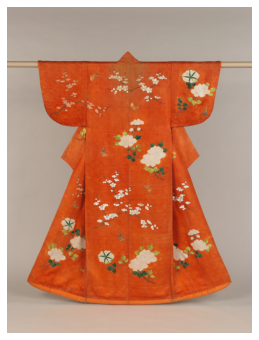

In [2]:
# view
raw_img = mpimg.imread("test/74364.jpg")
plt.figure(figsize=(6,6))
plt.axis('off')
plt.imshow(raw_img)
plt.show()

In [3]:
# check size
raw_img.shape

(2000, 1501, 3)

In [4]:
# load image
img1 = Image.open('test/74364.jpg')

In [5]:
# some parameters
w, h = img1.size
bg_side_len = (max(w,h), max(w,h)) # set the canvas size, with max width or length
dist = (h-w)/2 # distance from center

In [6]:
# initiate a black background
bg = Image.new('RGB', (bg_side_len), color = 'black')

# mirror along the longer side
if h > w:
    img2 = img1.transpose(Image.FLIP_LEFT_RIGHT) 

    bg.paste(img1, (int(dist),0))
    bg.paste(img2, (int(dist)+w,0))
    bg.paste(img2, (int(dist)-w,0))

if w > h:
    img2 = img1.transpose(Image.FLIP_TOP_BOTTOM) 

    bg.paste(img1, (int(dist),0))
    bg.paste(img2, (int(dist)+h,0))
    bg.paste(img2, (int(dist)-h,0))

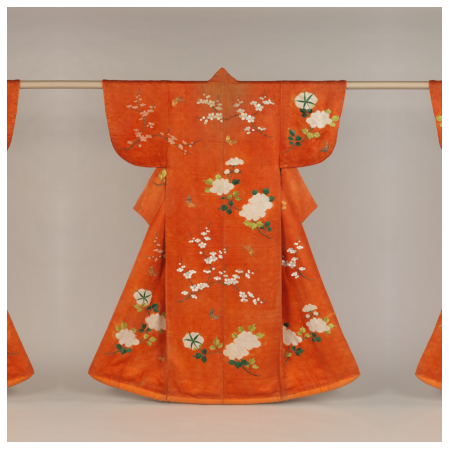

In [7]:
# checkout result
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(bg)
plt.show()

### define the function

In [8]:
def proc_img_square(filepath='test/74364.jpg'):
    # start timer
    start = time.time()

    # load image
    img1 = Image.open(filepath)

    # some parameters
    w, h = img1.size
    bg_side_len = (max(w,h), max(w,h)) # set the canvas size, with max width or length
    dist = (h-w)/2 # distance from center

    # initiate a black background
    bg = Image.new('RGB', (bg_side_len), color = 'black')

    # mirror along the longer side
    if h > w:
        img2 = img1.transpose(Image.FLIP_LEFT_RIGHT) 

        bg.paste(img1, (int(dist),0))
        bg.paste(img2, (int(dist)+w,0))
        bg.paste(img2, (int(dist)-w,0))

    if w > h:
        img2 = img1.transpose(Image.FLIP_TOP_BOTTOM) 

        bg.paste(img1, (int(dist),0))
        bg.paste(img2, (int(dist)+h,0))
        bg.paste(img2, (int(dist)-h,0))

        # checkout result
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.imshow(bg)
    plt.show()

    # timer ends
    end = time.time()
    print(f'it took {end-start} seconds to process this image.')

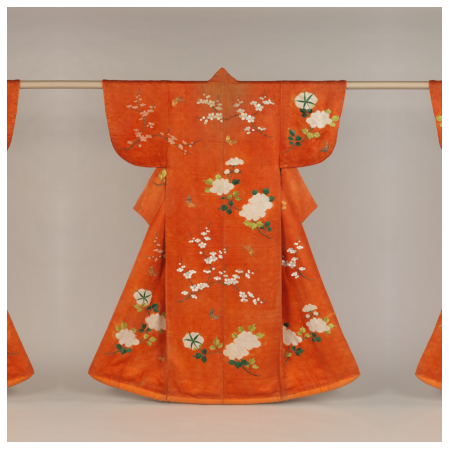

it took 0.3960893154144287 seconds to process this image.


In [9]:
# test
proc_img_square()

## process

### checkout asian clothes

In [29]:
dimension_df('clean image/asian_art_sel')

explict the square counts: {'horizontal': 118, 'vertical': 71}
rough square counts: {'horizontal': 111, 'vertical': 62, 'square': 16}


Object ID width height       ratio rough ratio
0      126312  1500   2111    vertical    vertical
1      126722  1250   2757    vertical    vertical
2      127542  1400   2418    vertical    vertical
3       39317  2000   1604  horizontal  horizontal
4       39747  3811   3049  horizontal  horizontal
..        ...   ...    ...         ...         ...
184     88303  1227   2439    vertical    vertical
185     88308  1250   2757    vertical    vertical
186     88350  1800   1636  horizontal      square
187     93922  1425   2450    vertical    vertical
188     95811  1550   2244    vertical    vertical

[189 rows x 5 columns]

### checkout all clothes

In [30]:
dimension_df('clean image/full_selection_sel')

explict the square counts: {'vertical': 2186, 'horizontal': 378, 'square': 1}
rough square counts: {'vertical': 2081, 'horizontal': 295, 'square': 189}


Object ID width height     ratio rough ratio
0       100017   991   1795  vertical    vertical
1       100019  1800   1898  vertical      square
2       100020  1440   2526  vertical    vertical
3       100021  1663   1960  vertical    vertical
4       100024  1225   2838  vertical    vertical
...        ...   ...    ...       ...         ...
2560     98751  2949   3892  vertical    vertical
2561     99061  1850   1885  vertical      square
2562     99070  1500   2250  vertical    vertical
2563     99509  3000   4000  vertical    vertical
2564     99989  1344   2184  vertical    vertical

[2565 rows x 5 columns]

**conclusions**

overall most clothes images are vertical, but most asian clothes are horizontal. 

### checkout test folder

In [8]:
dimension_df(directory)

explict the square counts: {'horizontal': 13, 'vertical': 12}
rough square counts: {'horizontal': 11, 'vertical': 11, 'square': 3}


Object ID width height       ratio rough ratio
0      70652   479    460  horizontal      square
1      70653  3150   2361  horizontal  horizontal
2      70721  2978   3722    vertical    vertical
3      70725  2129   1865  horizontal  horizontal
4      70727  1572   1396  horizontal  horizontal
5      70737  2760   1992  horizontal  horizontal
6      70770   474    476    vertical      square
7      70787  4000   3002  horizontal  horizontal
8      72358  4000   3300  horizontal  horizontal
9      73688  2504   1448  horizontal  horizontal
10     73692   751    604  horizontal  horizontal
11     74364  1501   2000    vertical    vertical
12     75903  1897   1520  horizontal  horizontal
13     76731  1456   1941    vertical    vertical
14     76735  4000   3000  horizontal  horizontal
15     78471  1312   1652    vertical    vertical
16     78933   728    500  horizontal  horizontal
17     79047  2236   2177  horizontal      square
18     79048  2978   3722    vertical    vertical
19     79091  1485   1861    vertical    vertical
20     79140  1152   2544    vertical    vertical
21     79169  1737   2856    vertical    vertical
22     79220  3200   4000    vertical    vertical
23     79648  1406   2722    vertical    vertical
24     79704  2978   3722    vertical    vertical